# 컴퓨터공학과 AIDML 202122029 김미연
# 전국무인교통단속카메라표준데이터 분석

## 사용 데이터
* 전국무인교통단속카메라 데이터 (Main data)  
* 한국도로공사_교통사고통계 데이터
* 전국가변전광표지판(안내전광판)표준데이터

## 분석 목표 및 주제
* 무인교통단속카메라의 전국 분포 확인.  
* 각종 법률과 무인교통단속카메라 설치와의 관계 확인.  
* 무인교통단속카메라와 안내전광판, 그리고 교통사고량 사이의 상관 관계 분석.

# 1. 무인교통단속카메라 표준데이터를 이용한 기초 분석

### Import Library

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
from matplotlib.pyplot import figure
from functools import reduce

### plot drawing을 위한 font 설정.

In [2]:
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

### 무인교통단속카메라 csv 데이터 가져오기

In [3]:
camera_df = pd.read_csv('National Unmanned Traffic Enforcement Camera Standard Data.csv', encoding='CP949')

### 데이터 확인

In [4]:
camera_df.head(3)

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,...,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명
0,G3408,제주특별자치도,제주시,시도,NaN,도령로,NaN,제주특별자치도 제주시 도령로 73,제주시 연동 2335-4,33.490106,...,50,NaN,NaN,NaN,NaN,제주특별자치도경찰청,064-798-3052,2021-01-28,1333203,경찰청 제주특별자치도경찰청
1,G3409,제주특별자치도,제주시,시도,NaN,화삼북로,NaN,제주특별자치도 제주시 건주로 27,제주시 도련1동 2002,33.517199,...,50,NaN,NaN,NaN,NaN,제주특별자치도경찰청,064-798-3052,2021-01-28,1333203,경찰청 제주특별자치도경찰청
2,G3410,제주특별자치도,서귀포시,지방도,1119,서성일로,NaN,제주특별자치도 서귀포시 성산읍 서성일로 1201,서귀포시 성산읍 고성리 1063-5,33.446475,...,50,1.0,2.4,NaN,NaN,제주특별자치도경찰청,064-798-3052,2021-01-28,1333203,경찰청 제주특별자치도경찰청


In [5]:
camera_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17810 entries, 0 to 17809
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   무인교통단속카메라관리번호  17810 non-null  object 
 1   시도명            17810 non-null  object 
 2   시군구명           17810 non-null  object 
 3   도로종류           17810 non-null  object 
 4   도로노선번호         15843 non-null  object 
 5   도로노선명          17810 non-null  object 
 6   도로노선방향         11938 non-null  float64
 7   소재지도로명주소       8340 non-null   object 
 8   소재지지번주소        16357 non-null  object 
 9   위도             17624 non-null  float64
 10  경도             17608 non-null  float64
 11  설치장소           17810 non-null  object 
 12  단속구분           17810 non-null  object 
 13  제한속도           17810 non-null  int64  
 14  단속구간위치구분       325 non-null    float64
 15  과속단속구간길이       410 non-null    float64
 16  보호구역구분         3560 non-null   float64
 17  설치연도           13241 non-null  float64
 18  관리기관명 

* 여러 column 중, **시도명**, **제한속도**, **설치연도** column을 중점적으로 이용하여 분석.

### 시도명 기준으로 count한 결과 출력 & plotting

In [6]:
camera_city_cnt = camera_df["시도명"].value_counts(dropna=False)
camera_city_cnt

경기도        5514
서울특별시      1791
충청남도       1622
전라북도        995
경상남도        982
전라남도        978
경상북도        961
인천광역시       955
부산광역시       885
대구광역시       795
강원도         773
대전광역시       550
광주광역시       303
01          281
제주특별자치도     205
울산광역시       110
충청북도         64
03           20
9            18
10            6
세종특별자치시       2
Name: 시도명, dtype: int64

### 의미없는 data 제거 function 작성.
* value_counts()를 통해 결측치 확인.


* 추후 여러 번 사용하기 위해 함수화.

In [7]:
def drop_trash(df, column_name, trash_data):

    for trash in trash_data:
        idx = df[df[column_name] == trash].index
        df = df.drop(idx)
    
    # 추후 indexing 문제를 방지하기 위해 index를 return하여 dataframe return.
    df.reset_index(drop=True)
    
    return df

### 시도명이 아닌 것으로 입력되어 있는 데이터들 제거.

In [8]:
trash_data = ['01', '03', '9', '10']
camera_df = drop_trash(camera_df, '시도명', trash_data)

### 결측치 제거 후 다시 출력해서 확인.

In [9]:
camera_city_cnt = camera_df["시도명"].value_counts(dropna=False)
camera_city_cnt

경기도        5514
서울특별시      1791
충청남도       1622
전라북도        995
경상남도        982
전라남도        978
경상북도        961
인천광역시       955
부산광역시       885
대구광역시       795
강원도         773
대전광역시       550
광주광역시       303
제주특별자치도     205
울산광역시       110
충청북도         64
세종특별자치시       2
Name: 시도명, dtype: int64

<AxesSubplot:xlabel='시도명', ylabel='무인단속카메라 수'>

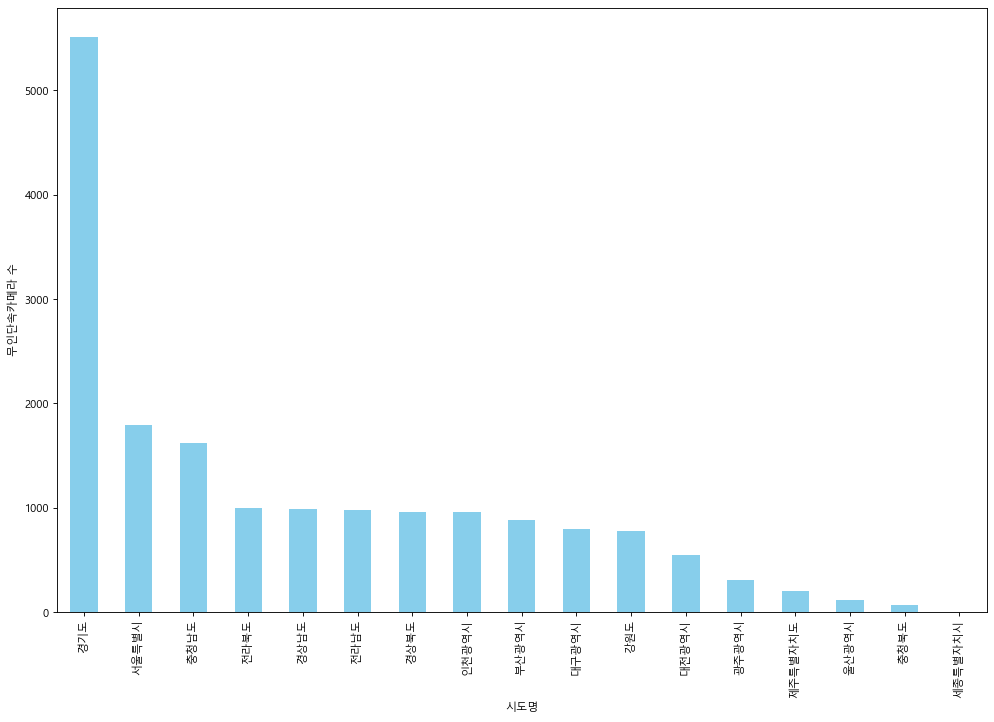

In [10]:
figure(figsize=(15, 10), dpi=80)
camera_city_cnt.plot.bar(color='skyblue', xlabel='시도명', ylabel='무인단속카메라 수')

* 무인카메라 수는 경기도가 압도적으로 많은 것으로 기록. 수도권인 점, 교통의 요지인 점이 주된 원인으로 작용한 듯.


* 하지만 누락된 data들이 많기 때문에(결측치 등) 정확한 정보는 아닐 수 있는 문제점이 존재.

### 설치연도 기준으로 count한 결과 출력 & plotting

In [11]:
camera_year_cnt = camera_df["설치연도"].value_counts(normalize=True, dropna=False).sort_index(ascending=True)
camera_year_cnt

2002.0    0.000172
2003.0    0.000229
2004.0    0.001144
2005.0    0.005548
2006.0    0.008293
2007.0    0.012697
2008.0    0.017158
2009.0    0.020475
2010.0    0.029568
2011.0    0.029740
2012.0    0.015613
2013.0    0.037346
2014.0    0.041636
2015.0    0.041750
2016.0    0.054046
2017.0    0.072634
2018.0    0.082242
2019.0    0.083615
2020.0    0.104947
2021.0    0.079840
NaN       0.261310
Name: 설치연도, dtype: float64

* 결측치가 얼마나 되는지 확인하기 위해 dropna option을 False로 두고, normalize 옵션을 True로 주고 실행.


* 결측치가 전체 데이터의 **25%** 를 차지하기 때문에 아주 정확한 정보라고 보기는 어려움.

<AxesSubplot:xlabel='시도명', ylabel='설치연도 count'>

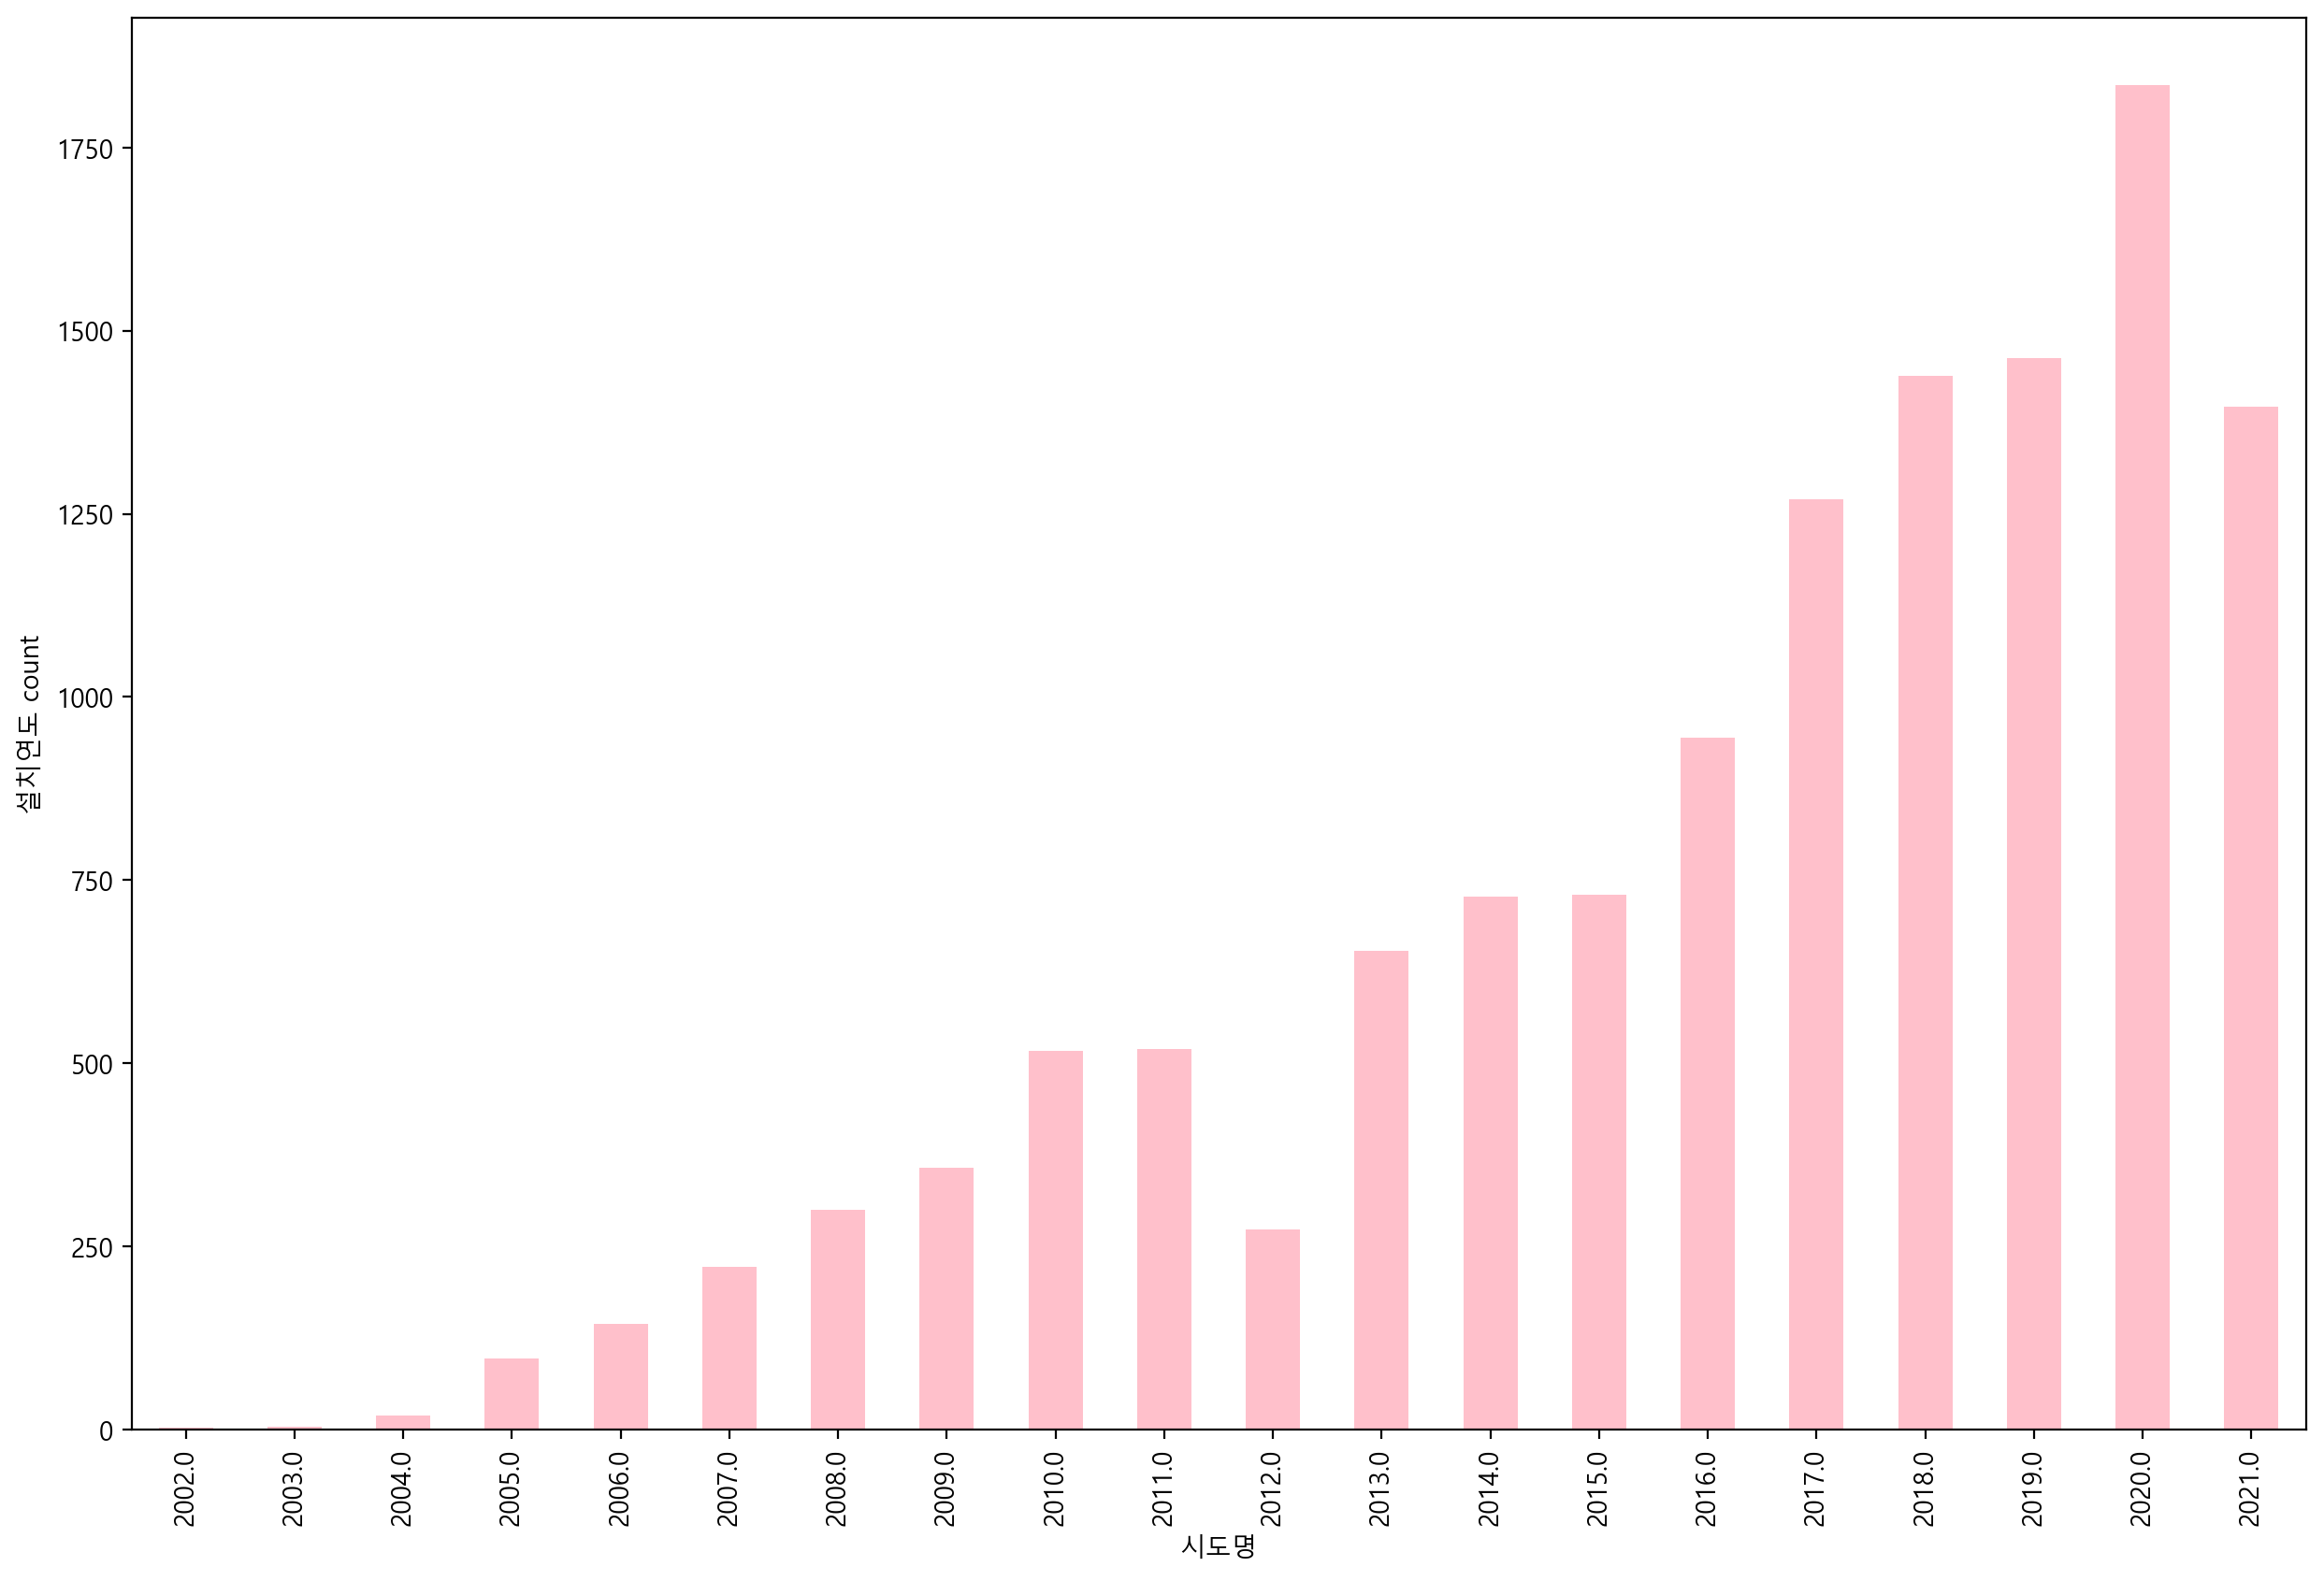

In [12]:
camera_year_cnt = camera_df["설치연도"].value_counts(dropna=True).sort_index(ascending=True)

figure(figsize=(15, 10), dpi=200)
camera_year_cnt.plot.bar(color='pink', xlabel='시도명', ylabel='설치연도 count')

### pct_change() 함수를 이용하여 전년도 대비 설치 수 증가율 비교.

In [13]:
camera_year_cnt_df = pd.DataFrame({'설치연도':camera_year_cnt.index, 'count':camera_year_cnt.values})
camera_year_cnt_df = pd.DataFrame(camera_year_cnt_df, columns=['설치연도', 'count'])

camera_year_cnt_df['increase_rate'] = camera_year_cnt_df['count'].pct_change()
camera_year_cnt_df

,설치연도,count,increase_rate
0,2002.0,3,NaN
1,2003.0,4,0.333333
2,2004.0,20,4.000000
3,2005.0,97,3.850000
4,2006.0,145,0.494845
5,2007.0,222,0.531034
6,2008.0,300,0.351351
7,2009.0,358,0.193333
8,2010.0,517,0.444134
9,2011.0,520,0.005803


## 설치연도와 관련된 고찰
* 2018, 2019년도에는 전체적으로 전년도 대비 일정한 증가율을 보임.  


* 그러나, **2020년도**에 설치 수가 전년도 대비 약 **25%** 증가한 것을 볼 수 있음.  


* 정확히 무엇과 관련이 있는 것인지를 알기 위해 **제한속도**와 함께 데이터를 분석.

In [14]:
camera_speedlimit_cnt = camera_df["제한속도"].value_counts(dropna=False, ascending=True)
camera_speedlimit_cnt

69        1
20       11
110      73
90       87
40      349
100     382
70     1171
80     1179
30     2631
50     3081
60     3351
0      5169
Name: 제한속도, dtype: int64

### 제한속도가 몇 km인지 알 수 없는 데이터(0, 사실상 결측치), 오타로 추정되는 데이터(69) 제거.

In [15]:
trash_data = [0, 69]
camera_df = drop_trash(camera_df, '제한속도', trash_data)

### 데이터 정제 후 증가율 재분석.

In [16]:
camera_year_cnt = camera_df["설치연도"].value_counts(dropna=True).sort_index(ascending=True)
camera_year_cnt_df = pd.DataFrame({'설치연도':camera_year_cnt.index, 'count':camera_year_cnt.values})
camera_year_cnt_df = pd.DataFrame(camera_year_cnt_df, columns=['설치연도', 'count'])

camera_year_cnt_df['increase_rate'] = camera_year_cnt_df['count'].pct_change()
camera_year_cnt_df

,설치연도,count,increase_rate
0,2002.0,3,NaN
1,2003.0,4,0.333333
2,2004.0,12,2.000000
3,2005.0,38,2.166667
4,2006.0,7,-0.815789
5,2007.0,58,7.285714
6,2008.0,116,1.000000
7,2009.0,221,0.905172
8,2010.0,379,0.714932
9,2011.0,380,0.002639


* 재분석 결과, 2020년에 전년도 대비 설치 수가 **31%** 증가한 것을 확인할 수 있었음.

### 제한속도 별 설치 수에 대한 plotting.

<AxesSubplot:xlabel='시도명', ylabel='제한속도 count'>

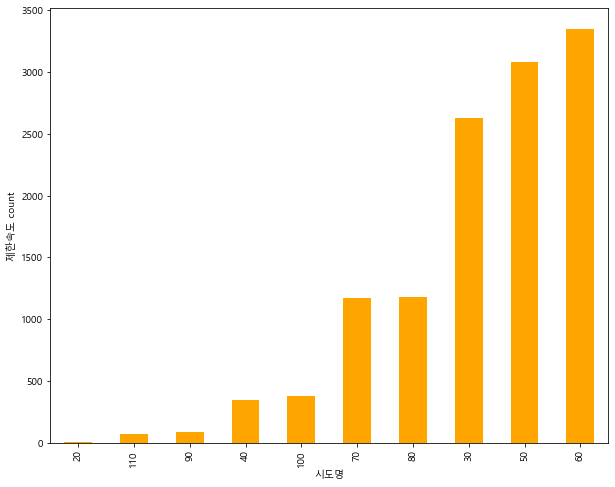

In [17]:
camera_speedlimit_cnt = camera_df["제한속도"].value_counts(dropna=False, ascending=True)
camera_speedlimit_cnt.plot.bar(figsize=(10, 8), color='orange', xlabel='시도명', ylabel='제한속도 count')

## 연도별 설치된 무인단속카메라의 제한속도 종류 분석
* 무인단속카메라 설치 수가 늘어난 2019년도와 2020년도 사이에 어떤 제한속도의 카메라가 많이 설치된 것인지를 분석.

In [18]:
camera_2021_df = camera_df.loc[camera_df['설치연도'] == 2021]
camera_2020_df = camera_df.loc[camera_df['설치연도'] == 2020]
camera_2019_df = camera_df.loc[camera_df['설치연도'] == 2019]
camera_2018_df = camera_df.loc[camera_df['설치연도'] == 2018]

### value_counts() 함수에서 series 형태로 return되는 결과를 DataFrame 형태로 만들어주는 function 작성.

In [19]:
def df_count(df, column, year):
    df = df[column].value_counts(dropna=True)
    return pd.DataFrame({column:df.index, year:df.values})

In [20]:
camera_2021_speedlimit_df = df_count(camera_2021_df, '제한속도', 2021)
camera_2020_speedlimit_df = df_count(camera_2020_df, '제한속도', 2020)
camera_2019_speedlimit_df = df_count(camera_2019_df, '제한속도', 2019)
camera_2018_speedlimit_df = df_count(camera_2018_df, '제한속도', 2018)

### 연도별 계산 결과를 merge.

In [21]:
data_frames = [camera_2018_speedlimit_df, camera_2019_speedlimit_df, camera_2020_speedlimit_df, camera_2021_speedlimit_df]
speedlimit_by_year_df = reduce(lambda  left,right: pd.merge(left,right,on=['제한속도'], how='outer'), data_frames)

In [22]:
speedlimit_by_year_df

,제한속도,2018,2019,2020,2021
0,60,320.0,350.0,278.0,133
1,50,277.0,345.0,363.0,212
2,30,188.0,260.0,677.0,788
3,70,129.0,101.0,93.0,59
4,80,107.0,93.0,100.0,62
5,40,26.0,41.0,69.0,54
6,90,26.0,14.0,1.0,6
7,100,17.0,15.0,14.0,19
8,110,NaN,2.0,5.0,14
9,20,NaN,NaN,NaN,2


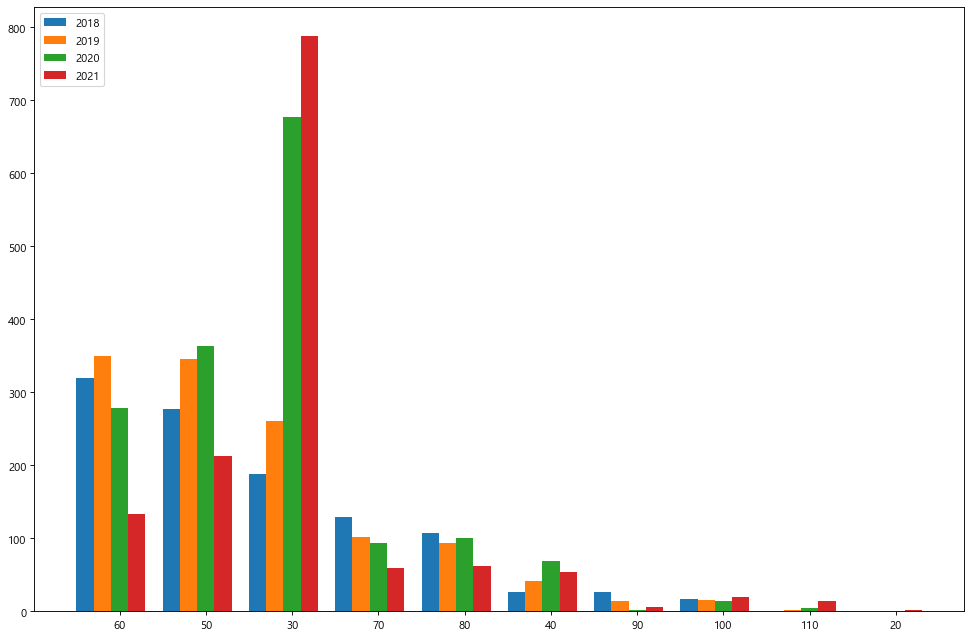

In [23]:
figure(figsize=(15, 10), dpi=80)
  
X_axis = np.arange(len(speedlimit_by_year_df))

plt.bar(X_axis - 0.4, speedlimit_by_year_df[2018], 0.2, label = '2018')
plt.bar(X_axis - 0.2, speedlimit_by_year_df[2019], 0.2, label = '2019')
plt.bar(X_axis + 0.0, speedlimit_by_year_df[2020], 0.2, label = '2020')
plt.bar(X_axis + 0.2, speedlimit_by_year_df[2021], 0.2, label = '2021')
  
plt.xticks(X_axis, speedlimit_by_year_df['제한속도'])
plt.legend()
plt.show()

* 2018, 2019년도에 비해 2020, 2021년도에는 **제한속도 30km/h**인 무인단속카메라가 매우 많이 설치된 것을 확인 가능.


(출처 : https://news.kbs.co.kr/news/view.do?ncd=4357445)
<div align="center"><img src='민식이법.png'></div>


* **'민식이법'** 이라고도 불리는 2019년 12월 도로교통법 개정안은 어린이보호구역 내에 과속단속 카메라와 신호등 설치를 의무화한다는 내용.


* 그래프가 해당 양상을 띄는 이유는 민식이법 때문으로 유추 가능.


* 신호등 표준 데이터도 있었으나, 신호등 설치연도가 csv 파일에 포함되어 있지 않아 함께 분석이 불가능했던 한계점 존재.

(출처 : https://www.yna.co.kr/view/AKR20201110052600530)
<div align="center"><img src='5030.png'></div>


* 또한, 2020년 11월 시작된 **안전속도 5030 캠페인**도 영향을 줬을 것으로 보임.


* 21년 4월부터 전국적으로 도시 내 일반도로의 제한속도가 50km/h으로 하향이 되었으나, 아직 60km/h인 곳이 많이 남아있음.


* 또한, 50으로 새롭게 설치된 것이 아닌 60이었다가 50으로 바뀐 것은 설치연도로 집계되지 않아 통계로 알아볼 수는 없었음.

# 2. 교통사고 발생 수와의 상관관계 비교
* 무인단속카메라가 전체적으로 늘어나고 있는 추세인데, 교통사고 발생 수와는 어떤 상관관계가 있을지 비교.


* **한국도로공사 교통사고통계 데이터**(https://www.data.go.kr/data/15045638/fileData.do) 를 사용.


* 추가적으로, 도로에 설치된 **안내전광판**과는 어떤 상관관계를 나타낼지 추가적으로 알아봄.


* 이를 위해 **전국가변전광표지판(안내전광판)표준데이터**(https://www.data.go.kr/data/15034544/standard.do) 를 사용.

### 교통사고통계 csv 데이터 가져오기

In [24]:
accident_df = pd.read_csv('한국도로공사_교통사고통계_20201231.csv', encoding='CP949')
accident_df

,연도,사고,사망,부상
0,2000,3910,569,2845
1,2001,3638,456,2331
2,2002,3957,421,2115
3,2003,3585,348,1843
4,2004,3242,300,1555
5,2005,2880,249,1170
6,2006,2583,284,1131
7,2007,2550,283,1114
8,2008,2449,265,955
9,2009,2374,248,1031


### 교통사고통계 데이터의 기초 통계 정보 출력.

In [25]:
accident_df[['사고', '사망', '부상']].describe()

,사고,사망,부상
count,21.000000,21.000000,21.000000
mean,2669.190476,293.285714,1369.619048
std,633.728934,95.275990,542.829022
min,1834.000000,176.000000,830.000000
25%,2251.000000,239.000000,983.000000
50%,2496.000000,265.000000,1148.000000
75%,2880.000000,343.000000,1619.000000
max,3957.000000,569.000000,2845.000000


### 유사 dataset : 안내전광판 csv 데이터 가져오기
(도로에 설치된 도로 교통 안내전광판의 모습, 출처 : https://blog.daum.net/ldj9485/17428134)
<div align="center"><img src='안내전광판.png'></div>

In [26]:
board_df = pd.read_csv('전국가변전광표지판(안내전광판)표준데이터.csv', encoding='CP949')
board_df.head(3)

,가변전광표지판명,시도명,시군구명,시군구코드,도로종류,도로노선명,도로노선번호,도로노선방향,위도,경도,...,표출색상,표시유형코드,출력크기,제공정보종류,설치연도,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명
0,삼락IC,부산광역시,사상구,26530,지방,강변대로,7711번,NaN,35.186819,128.977112,...,NaN,2,2단10열,01+02+03+04,2010,부산광역시 교통정보서비스센터,051-600-0255,2021-08-04,6260000,부산광역시
1,서면롯데호텔,부산광역시,부산진구,26230,지방,가야대로,30번,NaN,35.157813,129.053622,...,NaN,2,2단10열,01+02+03+04,2010,부산광역시 교통정보서비스센터,051-600-0255,2021-08-04,6260000,부산광역시
2,서부산IC,부산광역시,강서구,26440,지방,공항로,31번,NaN,35.161029,128.957485,...,NaN,2,2단10열,01+02+03+04,2010,부산광역시 교통정보서비스센터,051-600-0255,2021-08-04,6260000,부산광역시


## 무인단속카메라, 안내전광판, 교통사고 수 사이의 correlation 분석.

In [27]:
camera_cnt_df = camera_year_cnt_df[['설치연도', 'count']]
accident_cnt_df = accident_df[['연도', '사고', '사망', '부상']]

board_cnt = board_df["설치연도"].value_counts(dropna=True).sort_index(ascending=True)
board_cnt_df = pd.DataFrame({'연도':board_cnt.index, '전광판 설치 수':board_cnt.values})
board_cnt_df = pd.DataFrame(board_cnt_df, columns=['연도', '전광판 설치 수'])

## merge를 위한 column명 변경

In [28]:
camera_cnt_df.columns = ['연도', '무인단속카메라 설치 수']

In [29]:
data_frames = [accident_cnt_df, camera_cnt_df, board_cnt_df]
cnts_df = reduce(lambda  left,right: pd.merge(left,right,on=['연도'], how='outer'), data_frames)

cnts_df

,연도,사고,사망,부상,무인단속카메라 설치 수,전광판 설치 수
0,2000.0,3910.0,569.0,2845.0,NaN,2.0
1,2001.0,3638.0,456.0,2331.0,NaN,NaN
2,2002.0,3957.0,421.0,2115.0,3.0,19.0
3,2003.0,3585.0,348.0,1843.0,4.0,60.0
4,2004.0,3242.0,300.0,1555.0,12.0,6.0
5,2005.0,2880.0,249.0,1170.0,38.0,60.0
6,2006.0,2583.0,284.0,1131.0,7.0,153.0
7,2007.0,2550.0,283.0,1114.0,58.0,150.0
8,2008.0,2449.0,265.0,955.0,116.0,138.0
9,2009.0,2374.0,248.0,1031.0,221.0,480.0


### 결측치 제거 (설치 수가 NaN인 2000, 2001년, 사고 수가 NaN인 2021년 data 제거 위함)

In [30]:
trash_data = [2000, 2001, 2021]
cnts_df = drop_trash(cnts_df, '연도', trash_data)
cnts_df

,연도,사고,사망,부상,무인단속카메라 설치 수,전광판 설치 수
2,2002.0,3957.0,421.0,2115.0,3.0,19.0
3,2003.0,3585.0,348.0,1843.0,4.0,60.0
4,2004.0,3242.0,300.0,1555.0,12.0,6.0
5,2005.0,2880.0,249.0,1170.0,38.0,60.0
6,2006.0,2583.0,284.0,1131.0,7.0,153.0
7,2007.0,2550.0,283.0,1114.0,58.0,150.0
8,2008.0,2449.0,265.0,955.0,116.0,138.0
9,2009.0,2374.0,248.0,1031.0,221.0,480.0
10,2010.0,2368.0,353.0,983.0,379.0,312.0
11,2011.0,2640.0,265.0,1731.0,380.0,453.0


### Heatmap을 통한 Pearson Correlation 분석.

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0, 0.5, '사고'),
  Text(0, 1.5, '사망'),
  Text(0, 2.5, '부상'),
  Text(0, 3.5, '무인단속카메라 설치 수'),
  Text(0, 4.5, '전광판 설치 수')])

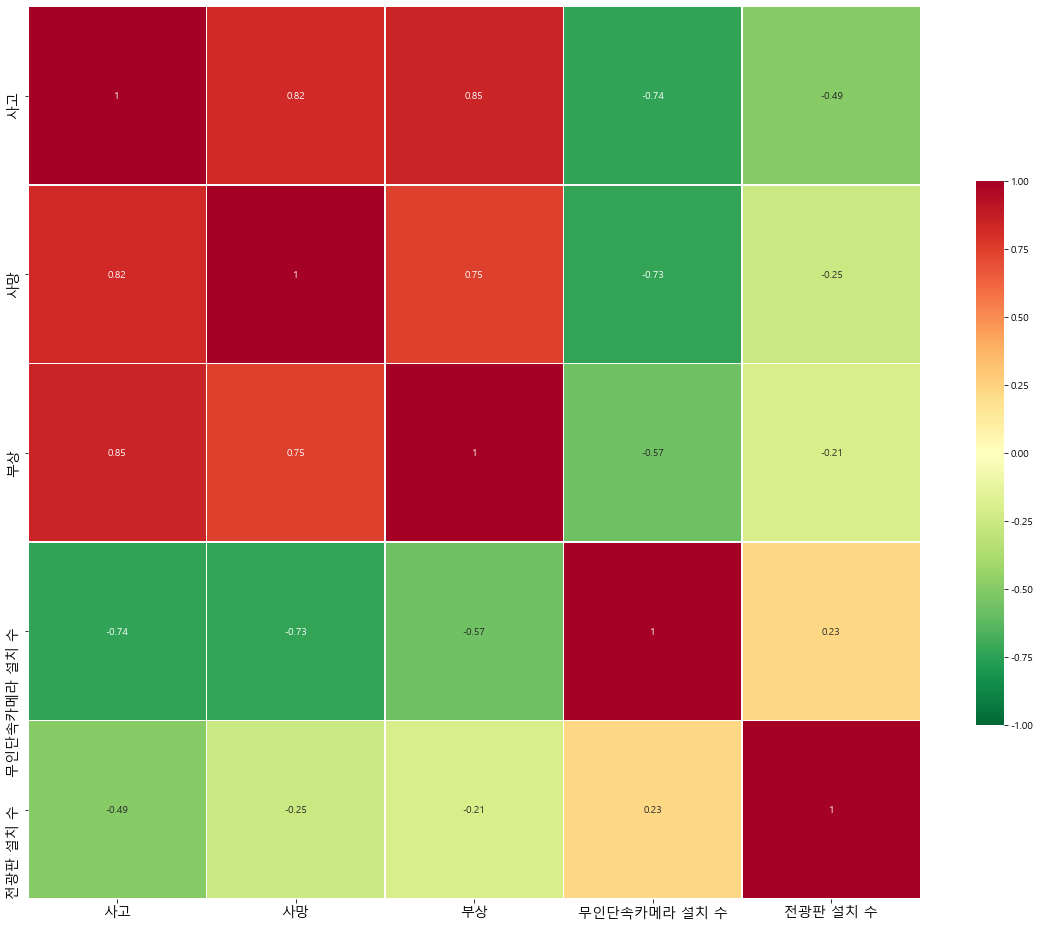

In [31]:
corr = cnts_df[['사고', '사망', '부상', '무인단속카메라 설치 수', '전광판 설치 수']].corr(method='pearson')
plt.figure(figsize=(20,20))
ax = sns.heatmap(corr, annot=True,
            linewidths=.5,
            cbar_kws={"shrink": .5},
            vmin = -1,vmax = 1,
            square=True, cmap='RdYlGn_r')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

## 사고 수와 무인단속카메라 설치 수는 강한 음의 상관관계를 보임을 알 수 있음.


* 하지만, 사고 수가 무인단속카메라 설치 수에만 의존한다고 판단하면 성급한 일반화의 오류를 범할 수 있음.


* 더 많은 교통요인과 함께 분석할 필요성이 있음.


## 앞으로의 분석 방향 (중간 발표 이후)


* 무인단속카메라, 전광판 외에 **다른 교통 지표들**도 적용해서 상관관계 도출 예정(교통량 data 등).


* 또한, 무인단속카메라 설치 위치와 사고 발생 지역을 비교하여 설치가 필요한 곳을 예측해보는 활동 진행 예정.


* 이를 위해 **도로교통공단_사망 교통사고 정보**(https://www.data.go.kr/data/15070340/fileData.do) 데이터 사용 예정.